# Setup

Import basic packages and bring in lookup tables for clinical conditions and medications and pre-defined mapping functions.

#### Packages

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
# set number of rows pandas dataframe displays
pd.set_option('display.max_rows', 3000)

#### Lookup tables

In [2]:
lkp_med = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_medical_table.csv', sep=',')
lkp_med_code_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_code_dic.p', 'rb'))
lkp_med_term_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_term_dic.p', 'rb'))

lkp_bnf = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_bnf_table.csv', 
                      sep=',', dtype={'bnfcode':str, 'bnf':str})

lkp_prd = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_product_table.csv', sep=',', 
                      low_memory=False)

#### Mappings from helper_functions

In [3]:
from helper_functions import medcode_to_read, medcode_to_term, read_to_medcode, cprd_to_bnf, bnf_to_chapter

#### Disease readcode lists

Predominantly taken from ClinicalCodes.org

In [4]:
# diabetes
db_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\diabetes.csv', sep=',')
diabetes_readcodes = list(db_csv['code'])

# heart-failure
hf_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\heart-failure.csv', sep=',')
heartfailure_readcodes = list(hf_csv['code'])

# thrombosis
tm_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res25-p16_thrombosis.csv', sep=',')
thrombosis_readcodes = list(tm_csv['code'])

# mild-liver-disease
ld_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-mild-liver-disease.csv', sep=',')
liverdisease_readcodes = list(ld_csv['code'])

# renal-disease
rd_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-renal-disease.csv', sep=',')
renaldisease_readcodes = list(rd_csv['code'])

# hypertension
ht_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\hypertension.csv', sep=',')
hypertension_readcodes = list(ht_csv['code'])

Construct disease_dic from the readcodes specified above, to feed into the build_data function

In [5]:
disease_dic = {'db':diabetes_readcodes,
               'hf':heartfailure_readcodes,
               'tm':thrombosis_readcodes,
               'ld':liverdisease_readcodes,
               'rd':renaldisease_readcodes,
               'ht':hypertension_readcodes}

# Bring in stat_dic

There is a stat_dic which contains statistics realting to all patients sampled for each specific drug.

In [6]:
stat_dic = pickle.load(open('stat_dic_135.p', 'rb')) # read pickle file

#### Infer targets avaliable from stat_dic

By indexing the first avaliable entry.

In [7]:
target_list = list(stat_dic[list(stat_dic.keys())[0]]['target'].keys())

#### Get negative patids for each version

There is one version of negative patients for hospital admissions indicating a serious ADR and another for drug specific side-effects.

In [8]:
patids_neg_dic = {'v1':[patid for patid in list(stat_dic.keys()) 
                        if stat_dic[patid]['target']['patids_v1_neg'][0]==1],
                  'v2':[patid for patid in list(stat_dic.keys()) 
                        if stat_dic[patid]['target']['patids_v2_neg'][0]==1]}

#### Create a x month filters

That will be applied to positive patids when projecting from the minimum date of prescription to filter to include only patients that incur the event(s) of interest x months from the first date of prescription.

In [9]:
filter_0_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<=0:
        filter_0_mnth.append(patid)
        
filter_6_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<185:
        filter_6_mnth.append(patid)
        
filter_12_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<365:
        filter_12_mnth.append(patid)
        
filter_24_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<730:
        filter_24_mnth.append(patid)
        
filter_60_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<1825:
        filter_60_mnth.append(patid)
        
filter_120_mnth = []
for patid in list(stat_dic.keys()):
    if stat_dic[patid]['drug_duration_max']<3650:
        filter_120_mnth.append(patid)

#### Target and prediction type definitions

We can build a classifier to predict within X months of first prescription by changing the filter above.

In [10]:
target_dic = {'patids_v1a_pos':'EHA',
              'patids_v1b_pos':'HC',
              'patids_v1c_pos':'A&E',
              'patids_v1d_pos':'ANY_HOS',
              'patids_v1e_pos':'ANY_HOS_MR',
              'patids_v1f_pos':'ANY_HOS_MC',
              'patids_v1g_pos':'ANY_HOS_CNI',
              'patids_v2a_pos':'SE',
              'patids_v2b_pos':'SE_MR',
              'patids_v2c_pos':'SE_MC',
              'patids_v2d_pos':'SE_CNI'}

eventdate_dic = {'eventdate_min':'Within 6 months of first prescription',
                 'eventdate_max_6':'Within 6 months'}

# Classifiers

#### Packages

Packages imported from SKLearn, XGBoost and user-defined functions

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from helper_functions import add_neg_patids, build_data

Cross-validation will be done over 5 folds

In [12]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)

## 1. 5-fold CV over avaliable targets - 6 months

#### Define parameters to cross-validate over

In this case we perform cross validation using XGBoost with generic parameters that have been observered to perform reasonably on the data. See XGBoost documentation for justification of objective and eval_metric suitability.

In [13]:
eventdate_list = ['eventdate_min', 'eventdate_max_6']

feature_dic = {'patient_profile':True,
               'drug_metrics_profile':True,
               'bnf_profile':True,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':True}

# these parameters have been chosen as reasonable parameters to give an indication of potential accuracy
params = {'max_depth':4, 'eta':0.3, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':10}
num_boost_round = 200

#### Run cross-validation

In [14]:
results = []
results_formatted = []

# predict targets from each eventdate
for eventdate in eventdate_list:

    # loop  through all targets in the stat_dic
    for target in target_list:
        # set up to predict positive instances (negative instances are obtains from the add_neg_patids function)
        if target[-3:]=='pos':
            patids_pos = [patid for patid in list(stat_dic.keys()) 
                                if stat_dic[patid]['target'][target][0]==1]
            # version for the add_neg_patids function
            version = target[7:9]

            # if projecting from minimum date, apply a maximum filter to the allowable duration to the target date
            if eventdate=='eventdate_min':
                patids_pos = list(set.intersection(set(patids_pos), set(filter_6_mnth)))
                # apply the same filter to negative cases
                patids_neg = list(set(patids_neg_dic[version]) - set(filter_6_mnth))
            else:
                patids_neg = patids_neg_dic[version]
                
            # get an unbalanced set of positive and negative patids (without filter applied)
            patids = patids_pos + patids_neg              
            random.seed(0)
            random.shuffle(patids)

            # build data and apply SKLearn k-fold split
            X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                                   lkp_bnf, lkp_prd, eventdate, target, tdqm_display=False)
            k_fold_index_set = list(kf.split(X))
            
            # get weights for the unbalanced data
            w_0 = len(y) / (2 * sum(y==0))
            w_1 = len(y) / (2 * sum(y==1))

            # initialize training and test auc score lists
            tr_au = []
            te_au = []
            
            evals_result = {}

            for fold in range(k_folds):
                # split the data in to the k-th fold using SKLearn k-fold split
                train_idx, test_idx = k_fold_index_set[fold]
                X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]

                # get data in required format for XGBoost - basic WEIGHTING for unbalanced data
                dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                                     weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
                dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                                    weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test]) 
                
                # using Learning API in XGBoost so that can store feature_names within the dMatrix
                evals = [(dtrain, 'dtrain'), (dtest, 'dtest')] # early stopping on the last item in evals (so test)
                model = xgb.train(params, dtrain, num_boost_round, evals, early_stopping_rounds=20, 
                                  evals_result=evals_result, verbose_eval=False)

                # get accuracy score from evals_test for train and test based on best iter then append to score lists
                tr_au.append(list(evals_result['dtrain'].values())[0][model.best_iteration])
                te_au.append(list(evals_result['dtest'].values())[0][model.best_iteration])

            # calculate mean and standard deviation over the k-fold cross validation and append to results lists
            result = [eventdate, 
                      target, 
                      round(np.mean(np.array(tr_au)),3), 
                      round(np.std(np.array(tr_au)),3), 
                      round(np.mean(np.array(te_au)),3), 
                      round(np.std(np.array(te_au)),3)]
            results.append(result)
            
            result_formatted = [eventdate_dic[eventdate],
                                target_dic[target], 
                                f'{round(np.mean(np.array(tr_au)),2)}+/-{round(np.std(np.array(tr_au)),2)}',
                                f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),2)}']
            results_formatted.append(result_formatted)

            # print result to screen for checking progress
            print(result_formatted)
            
# save results
pickle.dump(results, open(r'Results\\results_target_CV_unbalanced_135.p', 'wb'))
pickle.dump(results_formatted, open(r'Results\\results_target_CV_unbalanced_formatted_135.p', 'wb'))

['Within 6 months of first prescription', 'EHA', '0.86+/-0.01', '0.8+/-0.01']
['Within 6 months of first prescription', 'HC', '0.81+/-0.01', '0.76+/-0.01']
['Within 6 months of first prescription', 'A&E', '0.86+/-0.02', '0.75+/-0.03']
['Within 6 months of first prescription', 'ANY_HOS', '0.82+/-0.0', '0.77+/-0.01']
['Within 6 months of first prescription', 'ANY_HOS_MR', '0.84+/-0.03', '0.77+/-0.02']
['Within 6 months of first prescription', 'ANY_HOS_MC', '0.89+/-0.05', '0.66+/-0.06']
['Within 6 months of first prescription', 'ANY_HOS_CNI', '0.81+/-0.01', '0.77+/-0.01']
['Within 6 months of first prescription', 'SE', '0.76+/-0.01', '0.73+/-0.01']
['Within 6 months of first prescription', 'SE_MR', '0.8+/-0.02', '0.75+/-0.02']
['Within 6 months of first prescription', 'SE_MC', '0.91+/-0.03', '0.67+/-0.03']
['Within 6 months of first prescription', 'SE_CNI', '0.76+/-0.01', '0.73+/-0.01']
['Within 6 months', 'EHA', '0.81+/-0.01', '0.76+/-0.0']
['Within 6 months', 'HC', '0.78+/-0.01', '0.75+

Print formatted results to latex code for direct insertion in to report.

In [22]:
results_formatted = pickle.load(open('Results\\results_target_CV_unbalanced_formatted_135.p', 'rb'))
df = pd.DataFrame(results_formatted, columns=['Prediction Type','Target','Train AUC','Test AUC'])
print(df.to_latex(index=False))

\begin{tabular}{llll}
\toprule
                      Prediction Type &      Target &   Train AUC &    Test AUC \\
\midrule
Within 6 months of first prescription &         EHA & 0.86+/-0.01 &  0.8+/-0.01 \\
Within 6 months of first prescription &          HC & 0.81+/-0.01 & 0.76+/-0.01 \\
Within 6 months of first prescription &         A\&E & 0.86+/-0.02 & 0.75+/-0.03 \\
Within 6 months of first prescription &     ANY\_HOS &  0.82+/-0.0 & 0.77+/-0.01 \\
Within 6 months of first prescription &  ANY\_HOS\_MR & 0.84+/-0.03 & 0.77+/-0.02 \\
Within 6 months of first prescription &  ANY\_HOS\_MC & 0.89+/-0.05 & 0.66+/-0.06 \\
Within 6 months of first prescription & ANY\_HOS\_CNI & 0.81+/-0.01 & 0.77+/-0.01 \\
Within 6 months of first prescription &          SE & 0.76+/-0.01 & 0.73+/-0.01 \\
Within 6 months of first prescription &       SE\_MR &  0.8+/-0.02 & 0.75+/-0.02 \\
Within 6 months of first prescription &       SE\_MC & 0.91+/-0.03 & 0.67+/-0.03 \\
Within 6 months of first prescription

## 1b. 5-fold CV over different periods

#### Define parameters to cross-validate over

In this case we perform cross validation using XGBoost with generic parameters that have been observered to perform reasonably on the data. See XGBoost documentation for justification of objective and eval_metric suitability.

In [13]:
eventdate_list = ['eventdate_min', 'eventdate_max_6']

feature_dic = {'patient_profile':True,
               'drug_metrics_profile':True,
               'bnf_profile':True,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':True}

# these parameters have been chosen as reasonable parameters to give an indication of potential accuracy
params = {'max_depth':4, 'eta':0.3, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':10}
num_boost_round = 200

#### Run cross-validation

In [16]:
target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'

period_dic = {'0_mnth'  : filter_0_mnth, 
              '6_mnth'  : filter_6_mnth, 
              '12_mnth' : filter_12_mnth, 
              '24_mnth' : filter_24_mnth, 
              '60_mnth' : filter_60_mnth,
              '120_mnth': filter_120_mnth}

results = []
results_formatted = []

# predict targets over each period
for period_key, filter_list in list(period_dic.items()):

    # set up to predict positive instances (negative instances are obtains from the add_neg_patids function)
    patids_pos = [patid for patid in list(stat_dic.keys()) 
                        if stat_dic[patid]['target'][target][0]==1]
    # apply a maximum filter to the allowable duration to the target date
    patids_pos = list(set.intersection(set(patids_pos), set(filter_list)))
    
    # apply the same filter to the negative cases
    patids_neg = list(set(patids_neg_dic[version]) - set(filter_list))

    # get an unbalanced set of positive and negative patids
    patids = patids_pos + patids_neg
    random.seed(0)
    random.shuffle(patids)

    # build data and apply SKLearn k-fold split
    X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                           lkp_bnf, lkp_prd, eventdate, target, tdqm_display=False)
    k_fold_index_set = list(kf.split(X))

    # get weights for the unbalanced data
    w_0 = len(y) / (2 * sum(y==0))
    w_1 = len(y) / (2 * sum(y==1))

    # initialize training and test auc score lists
    tr_au = []
    te_au = []

    evals_result = {}

    for fold in range(k_folds):
        # split the data in to the k-th fold using SKLearn k-fold split
        train_idx, test_idx = k_fold_index_set[fold]
        X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]

        # get data in required format for XGBoost - basic WEIGHTING for unbalanced data
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                             weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
        dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                            weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test]) 

        # using Learning API in XGBoost so that can store feature_names within the dMatrix
        evals = [(dtrain, 'dtrain'), (dtest, 'dtest')] # early stopping on the last item in evals (so test)
        model = xgb.train(params, dtrain, num_boost_round, evals, early_stopping_rounds=20, 
                          evals_result=evals_result, verbose_eval=False)

        # get accuracy score from evals_test for train and test based on best iter then append to score lists
        tr_au.append(list(evals_result['dtrain'].values())[0][model.best_iteration])
        te_au.append(list(evals_result['dtest'].values())[0][model.best_iteration])

    # calculate mean and standard deviation over the k-fold cross validation and append to results lists
    result = [period_key, 
              round(np.mean(np.array(tr_au)),3), 
              round(np.std(np.array(tr_au)),3), 
              round(np.mean(np.array(te_au)),3), 
              round(np.std(np.array(te_au)),3)]
    results.append(result)

    result_formatted = [period_key,
                        f'{round(np.mean(np.array(tr_au)),2)}+/-{round(np.std(np.array(tr_au)),2)}',
                        f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),2)}']
    results_formatted.append(result_formatted)

    # print result to screen for checking progress
    print(result_formatted, len(patids_pos), len(patids_neg))

# save results
pickle.dump(results, open(r'Results\\results_period_CV_unbalanced_135.p', 'wb'))
pickle.dump(results_formatted, open(r'Results\\results_period_CV_unbalanced_formatted_135.p', 'wb'))

['0_mnth', '0.88+/-0.04', '0.78+/-0.03'] 342 18908
['6_mnth', '0.86+/-0.01', '0.8+/-0.01'] 829 17503
['12_mnth', '0.86+/-0.01', '0.82+/-0.01'] 1080 16380
['24_mnth', '0.86+/-0.01', '0.82+/-0.01'] 1536 14400
['60_mnth', '0.86+/-0.01', '0.83+/-0.01'] 2544 10001
['120_mnth', '0.87+/-0.01', '0.84+/-0.01'] 3984 4637


Print formatted results to latex code for direct insertion in to report.

In [23]:
results_formatted = pickle.load(open('Results\\results_period_CV_unbalanced_formatted_135.p', 'rb'))
df = pd.DataFrame(results_formatted, columns=['Period','Train AUC','Test AUC'])
print(df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
  Period &   Train AUC &    Test AUC \\
\midrule
  0\_mnth & 0.88+/-0.04 & 0.78+/-0.03 \\
  6\_mnth & 0.86+/-0.01 &  0.8+/-0.01 \\
 12\_mnth & 0.86+/-0.01 & 0.82+/-0.01 \\
 24\_mnth & 0.86+/-0.01 & 0.82+/-0.01 \\
 60\_mnth & 0.86+/-0.01 & 0.83+/-0.01 \\
120\_mnth & 0.87+/-0.01 & 0.84+/-0.01 \\
\bottomrule
\end{tabular}



## 2. 5-fold CV over features - 12 months

#### Define parameters to cross-validate over

For consistency we with the above we perform cross validation using XGBoost with generic parameters that have been observered to perform reasonably on the data. See XGBoost documentation for justification of objective and eval_metric suitability.

In [17]:
feature_dic = {'patient_profile':False,
               'drug_metrics_profile':False,
               'bnf_profile':False,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':False}

# these parameters have been chosen as reasonable parameters to give an indication of potential accuracy
params = {'max_depth':4, 'eta':0.3, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':10}
num_boost_round = 200

target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'

#### Run cross-validation

In [18]:
results = []
results_formatted = []

keys = set(feature_dic.keys())

patids_pos = [patid for patid in list(stat_dic.keys()) 
                    if stat_dic[patid]['target'][target][0]==1]
patids_pos = list(set.intersection(set(patids_pos), set(filter_12_mnth)))
patids_neg = list(set(patids_neg_dic[version]) - set(filter_12_mnth))

# get an unbalanced set of positive and negative patids
patids = patids_pos + patids_neg
random.seed(0)
random.shuffle(patids)

for i in range(1,len(keys)):
    for comb in combinations(keys-set(['bnf_pca_profile']), i):
        
        # turn features on for each key in the combination
        for key in list(comb):
            feature_dic[key]=True
            
        # build data and apply SKLearn k-fold split
        X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                               lkp_bnf, lkp_prd, eventdate, target, tdqm_display=False)
        k_fold_index_set = list(kf.split(X))
               
        # get weights for the unbalanced data
        w_0 = len(y) / (2 * sum(y==0))
        w_1 = len(y) / (2 * sum(y==1))
            
        # initialize training and test auc score lists
        tr_au = []
        te_au = []
        
        evals_result = {}

        for fold in range(k_folds):
            # split the data in to the k-th fold using SKLearn k-fold split
            train_idx, test_idx = k_fold_index_set[fold]
            X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]

            # get data in required format for XGBoost - basic WEIGHTING for unbalanced data
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                                 weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
            dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                                weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])
            
            # using Learning API in XGBoost so that can store feature_names within the dMatrix
            evals = [(dtrain, 'dtrain'), (dtest, 'dtest')] # early stopping on the last item in evals (so test)
            model = xgb.train(params, dtrain, num_boost_round, evals, early_stopping_rounds=20, 
                              evals_result=evals_result, verbose_eval=False)

            # get accuracy score from evals_test for train and test based on best iter then append to score lists
            tr_au.append(list(evals_result['dtrain'].values())[0][model.best_iteration])
            te_au.append(list(evals_result['dtest'].values())[0][model.best_iteration])

        # calculate mean and standard deviation over the k-fold cross validation and append to results lists
        result = [list(comb), 
                  round(np.mean(np.array(tr_au)),3), 
                  round(np.std(np.array(tr_au)),3), 
                  round(np.mean(np.array(te_au)),3), 
                  round(np.std(np.array(te_au)),3)]
        results.append(result)

        result_formatted = [list(comb), 
                            f'{round(np.mean(np.array(tr_au)),2)}+/-{round(np.std(np.array(tr_au)),2)}',
                            f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),2)}']
        results_formatted.append(result_formatted)

        # print result to screen for checking progress
        print(result_formatted)
        
        # turn features off for each key in the combination
        for key in list(comb):
            feature_dic[key]=False 
            
# save results
pickle.dump(results, open('Results\\results_feature_CV_unbalanced_135.p', 'wb'))
pickle.dump(results_formatted, open('Results\\results_feature_CV_unbalanced_formatted_135.p', 'wb'))

[['drug_metrics_profile'], '0.72+/-0.01', '0.72+/-0.02']
[['patient_profile'], '0.75+/-0.01', '0.71+/-0.02']
[['disease_profile'], '0.69+/-0.0', '0.69+/-0.01']
[['bnf_profile'], '0.81+/-0.01', '0.76+/-0.01']
[['drug_metrics_profile', 'patient_profile'], '0.8+/-0.01', '0.78+/-0.01']
[['drug_metrics_profile', 'disease_profile'], '0.77+/-0.01', '0.76+/-0.02']
[['drug_metrics_profile', 'bnf_profile'], '0.82+/-0.02', '0.76+/-0.01']
[['patient_profile', 'disease_profile'], '0.8+/-0.01', '0.77+/-0.02']
[['patient_profile', 'bnf_profile'], '0.86+/-0.01', '0.8+/-0.01']
[['disease_profile', 'bnf_profile'], '0.83+/-0.01', '0.78+/-0.01']
[['drug_metrics_profile', 'patient_profile', 'disease_profile'], '0.83+/-0.01', '0.81+/-0.01']
[['drug_metrics_profile', 'patient_profile', 'bnf_profile'], '0.86+/-0.01', '0.81+/-0.01']
[['drug_metrics_profile', 'disease_profile', 'bnf_profile'], '0.82+/-0.02', '0.78+/-0.02']
[['patient_profile', 'disease_profile', 'bnf_profile'], '0.86+/-0.0', '0.81+/-0.01']
[['d

Print formatted results to latex code for direct insertion in to report.

In [24]:
results_formatted = pickle.load(open('Results\\results_feature_CV_unbalanced_formatted_135.p', 'rb'))
df = pd.DataFrame(results_formatted, columns=['Feature Combination','Train AUC','Test AUC'])
print(df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
                               Feature Combination &   Train AUC &    Test AUC \\
\midrule
                            [drug\_metrics\_profile] & 0.72+/-0.01 & 0.72+/-0.02 \\
                                 [patient\_profile] & 0.75+/-0.01 & 0.71+/-0.02 \\
                                 [disease\_profile] &  0.69+/-0.0 & 0.69+/-0.01 \\
                                     [bnf\_profile] & 0.81+/-0.01 & 0.76+/-0.01 \\
           [drug\_metrics\_profile, patient\_profile] &  0.8+/-0.01 & 0.78+/-0.01 \\
           [drug\_metrics\_profile, disease\_profile] & 0.77+/-0.01 & 0.76+/-0.02 \\
               [drug\_metrics\_profile, bnf\_profile] & 0.82+/-0.02 & 0.76+/-0.01 \\
                [patient\_profile, disease\_profile] &  0.8+/-0.01 & 0.77+/-0.02 \\
                    [patient\_profile, bnf\_profile] & 0.86+/-0.01 &  0.8+/-0.01 \\
                    [disease\_profile, bnf\_profile] & 0.83+/-0.01 & 0.78+/-0.01 \\
[drug\_metrics\_profile, patient\_profi

## 3. EHA model trained on all 135 data - 12 months

### Get data

In [ ]:
# these parameters have been chosen as reasonable parameters to give an indication of potential accuracy
params = {'max_depth':4, 'eta':0.3, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':10}

target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'

patids_pos = [patid for patid in list(stat_dic.keys()) 
                    if stat_dic[patid]['target'][target][0]==1]
patids_pos = list(set.intersection(set(patids_pos), set(filter_12_mnth)))
patids_neg = list(set(patids_neg_dic[version]) - set(filter_12_mnth))

patids = patids_pos + patids_neg
random.seed(0)
random.shuffle(patids)

feature_dic = {'patient_profile':True,
               'drug_metrics_profile':True,
               'bnf_profile':True,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':True}

# get data
X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                       lkp_bnf, lkp_prd, eventdate, target, tdqm_display=True)

k_fold_index_set = list(kf.split(X))

# get weights for the unbalanced data
w_0 = len(y) / (2 * sum(y==0))
w_1 = len(y) / (2 * sum(y==1))

### Establish optimum number of training rounds

In [50]:
num_boost_round = 100

# initialize training and test auc score lists
tr_epoch_au = []
te_epoch_au = []

for fold in range(k_folds):
    
    evals_result = {}

    # split the data in to the k-th fold using SKLearn k-fold split
    train_idx, test_idx = k_fold_index_set[fold]
    X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]

    # get data in required format for XGBoost - basic WEIGHTING for unbalanced data
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                         weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                        weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    evals = [(dtrain, 'dtrain'), (dtest, 'dtest')] # early stopping on the last item in evals (so test)
    model = xgb.train(params, dtrain, num_boost_round, evals=evals,
                      evals_result=evals_result, verbose_eval=False)

    # get accuracy score from evals_test for train and test
    tr_epoch_au.append(np.array(list(evals_result['dtrain'].values())[0]))
    te_epoch_au.append(np.array(list(evals_result['dtest'].values())[0]))

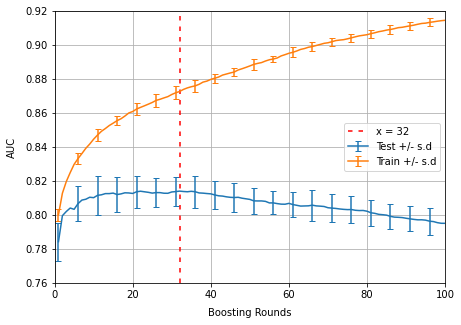

optimal training rounds: 32
optimal AUC: 0.813974


In [58]:
plt.figure(figsize=(7,5))
line_b = plt.errorbar((np.linspace(1,100,100)), np.mean(np.array(te_epoch_au), axis=0), 
             yerr=np.std(np.array(te_epoch_au), axis=0), errorevery=5, capsize=3, label='Test +/- s.d')

line_a = plt.errorbar((np.linspace(1,100,100)), np.mean(np.array(tr_epoch_au), axis=0), 
             yerr=np.std(np.array(tr_epoch_au), axis=0), errorevery=5, capsize=3, label='Train +/- s.d')
plt.xlabel('Boosting Rounds', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylabel('AUC', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylim(0.76,0.92)
plt.xlim(0,100)
plt.grid(True)
plt.axvline(x=np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1, color='red', linestyle=(0,(3,4)),
            label=f'x = {np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1}')
plt.legend(loc='center right')
plt.savefig('boosting_rounds.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

print(f'optimal training rounds: {np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1}')
print(f'optimal AUC: {np.max(np.mean(np.array(te_epoch_au), axis=0))}')

### Train on all data and save

In [174]:
num_boost_round = 32 # 32 from chart above

# get data in required format for XGBoost
ddata = xgb.DMatrix(X, label=y, feature_names=list(dic.values()),
                    weight=[w_0 if y_i==0 else w_1 for y_i in y])

# using Learning API in XGBoost so that can store feature_names within the dMatrix
evals_result = {}
evals = [(ddata, 'ddata')]
model = xgb.train(params, ddata, num_boost_round, evals=evals,
                  evals_result=evals_result, verbose_eval=False)

In [175]:
# save model
pickle.dump(model, open('model_eha_unbalanced_135.p', 'wb'))

### Evaluate

In [14]:
num_boost_round = 32 # from chart above

#### Threshold selection

In [15]:
# splitting in to 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=0)

# using scikit learn API so that can use precision_recall curve
model = xgb.XGBClassifier(n_estimators=num_boost_round, max_depth=4, learning_rate=0.3, objective='binary:logistic', 
                          min_child_weight=10, use_label_encoder=False)
fitted_model = model.fit(X_train, y_train, sample_weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train],
                         eval_metric='auc')

In [16]:
threshold=[]
f1_scores=[]
accuracy_scores=[]
precision_scores=[]
recall_scores=[]
roc_auc_scores=[]
for i in range(-100,100):
    threshold.append(0.5+i*0.005)
    f1_scores.append(f1_score(y_test, 
                              [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]]))
    accuracy_scores.append(accuracy_score(y_test, 
                                          [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]]))
    recall_scores.append(recall_score(y_test, 
                                      [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]],
                                      zero_division=0))
    precision_scores.append(precision_score(y_test, 
                                            [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]],
                                            zero_division=0))

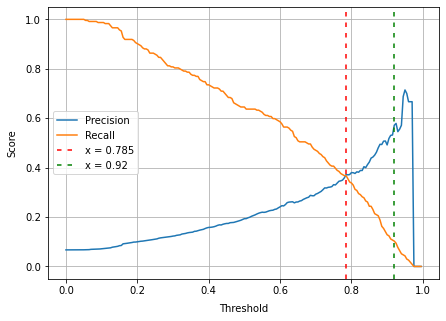

max f1 score: 0.36989247311827955
precision/recall at this point: 0.3722943722943723/0.36752136752136755

max accuracy score: 0.9347079037800687


In [54]:
plt.figure(figsize=(7,5))
plt.plot(threshold, precision_scores, label='Precision')
plt.plot(threshold, recall_scores, label='Recall')
plt.ylabel('Score', labelpad=8) # fontsize='large', fontweight='demibold'
plt.xlabel('Threshold', labelpad=8) # fontsize='large', fontweight='demibold'
plt.axvline(x=threshold[np.argmax(f1_scores)], color='red', linestyle=(0,(3,4)), 
                        label=f'x = {round(threshold[np.argmax(f1_scores)], 3)}')
plt.axvline(x=threshold[np.argmax(accuracy_scores)], color='green', linestyle=(0,(3,4)), 
                        label=f'x = {round(threshold[np.argmax(accuracy_scores)], 3)}')
plt.legend(loc='center left')
plt.grid(True)
plt.savefig('precision_recall_threshold.jpg', format='jpg', dpi=300)
plt.show()

print(f'max f1 score: {np.max(f1_scores)}')
print(f'precision/recall at this point: {precision_scores[np.argmax(f1_scores)]}/{recall_scores[np.argmax(f1_scores)]}')
print()
print(f'max accuracy score: {np.max(accuracy_scores)}')

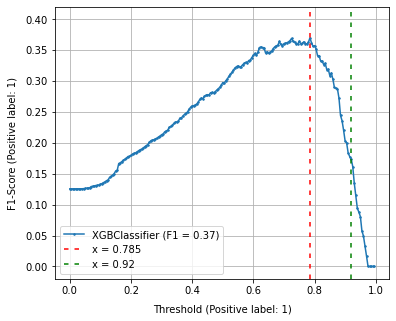

max accuracy score: 0.9347079037800687


In [19]:
plt.figure(figsize=(6,5))
plt.plot(threshold, f1_scores,
         label=f'XGBClassifier (F1 = {round(np.max(f1_scores),2)})',
         marker='.', markersize=3)
plt.ylabel('F1-Score (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'
plt.xlabel('Threshold (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'
plt.axvline(x=threshold[np.argmax(f1_scores)], color='red', linestyle=(0,(3,4)), 
                        label=f'x = {round(threshold[np.argmax(f1_scores)],3)}')
plt.axvline(x=threshold[np.argmax(accuracy_scores)], color='green', linestyle=(0,(3,4)), 
            label=f'x = {round(threshold[np.argmax(accuracy_scores)],3)}')
plt.legend(loc='lower left')
plt.grid(True)
plt.ylim(-0.02,0.42)
plt.savefig('f1_threshold.jpg', format='jpg', dpi=300)
plt.show()

print(f'max accuracy score: {np.max(accuracy_scores)}')

#### 20 runs for final evaluation metrics

In [22]:
threshold = 0.8 # inferred from charts above

In [23]:
np.random.seed(seed=0)

seed_list = np.random.randint(0, 1000000, 20)
print(seed_list)

[985772 305711 435829 117952 963395 152315 882371 359783 304137 122579
 610581 448242 374564 735831 736326 310744 170584 839052 604474 541377]


In [26]:
# initialize evaluation score lists
tr_au, tr_as, tr_ps, tr_rs, te_fs = [], [], [], [], []
te_au, te_as, te_ps, te_rs, te_fs = [], [], [], [], []

for seed in seed_list:
    # split the data in to train and test for each random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=seed)

    # get data in required format for XGBoost - basic WEIGHTING for unbalanced data (defined at X/y top level)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                         weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                        weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    model = xgb.train(params, dtrain, num_boost_round, verbose_eval=False)

    # calculate evaluation scores and append to score lists
    te_au.append(roc_auc_score(y_test, [pred for pred in model.predict(dtest, output_margin=True)]))
    te_as.append(accuracy_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_ps.append(precision_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_rs.append(recall_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_fs.append(f1_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    
    # print progress out
#     print(te_au[-1], te_as[-1], te_ps[-1], te_rs[-1], te_fs[-1])

# calculate mean and standard deviation over the k-fold cross validation and append to results lists
results = [te_au, te_as, te_ps, te_rs, te_fs]

result_formatted = [f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),3)}',
                    f'{round(np.mean(np.array(te_as)),2)}+/-{round(np.std(np.array(te_as)),3)}',
                    f'{round(np.mean(np.array(te_ps)),2)}+/-{round(np.std(np.array(te_ps)),3)}',
                    f'{round(np.mean(np.array(te_rs)),2)}+/-{round(np.std(np.array(te_rs)),3)}',
                    f'{round(np.mean(np.array(te_fs)),2)}+/-{round(np.std(np.array(te_fs)),3)}']

# print final formatted result to screen
print(result_formatted)
            
# save results
pickle.dump(results, open('Results\\results_final_20_unbalanced_135.p', 'wb'))

['0.81+/-0.013', '0.92+/-0.004', '0.36+/-0.035', '0.32+/-0.03', '0.34+/-0.03']


#### Precision-recall and ROC curves

In [21]:
# selected a seed from seed_list above for printing out example charts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=604474)

# get data in required format for XGBoost - basic WEIGHTING for unbalanced data (defined at X/y top level)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                     weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                    weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

# using Learning API in XGBoost so that can store feature_names within the dMatrix
example_model = xgb.train(params, dtrain, num_boost_round, verbose_eval=False)

# predictions from example model
preds = [pred for pred in example_model.predict(dtest, output_margin=True)]

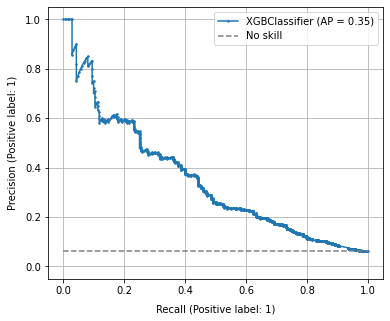

In [24]:
precision, recall, _ = precision_recall_curve(y_test, preds) # , sample_weight=sample_weight)
# sample_weight = [w_0 if y_test_i==0 else w_1 for y_test_i in y_test]

plt.figure(figsize=(6,5))
plt.plot(recall, precision, 
         label=f'XGBClassifier (AP = {round(average_precision_score(y_test, preds),2)})', # sample_weight=
         marker='.', markersize=3)
# calculate the no skill line as the proportion of the positive class
plt.plot([sum(y_test)/len(y_test), sum(y_test)/len(y_test)], color='grey', linestyle='dashed', label='No skill')
plt.legend(loc='upper right')
plt.ylim(-0.05,1.05)
plt.ylabel('Precision (Positive label: 1)', labelpad=8)
plt.xlabel('Recall (Positive label: 1)', labelpad=8)
plt.grid(True)
plt.savefig('precision_recall_curve.jpg', format='jpg', dpi=300)
plt.show()

In [37]:
# selected a seed from seed_list above for printing out example charts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=985772)

# get data in required format for XGBoost - basic WEIGHTING for unbalanced data (defined at X/y top level)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                     weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                    weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

# using Learning API in XGBoost so that can store feature_names within the dMatrix
example_model = xgb.train(params, dtrain, num_boost_round, verbose_eval=False)

# predictions from example model
preds = [pred for pred in example_model.predict(dtest, output_margin=True)]

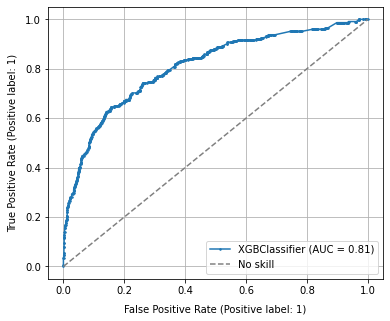

In [38]:
fpr, tpr, _ = roc_curve(y_test, preds) # , sample_weight=sample_weight)
# sample_weight = [w_0 if y_test_i==0 else w_1 for y_test_i in y_test]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, 
         label=f'XGBClassifier (AUC = {round(roc_auc_score(y_test, preds),2)})', # sample_weight=
         marker='.', markersize=3)
# calculate the no skill line as the proportion of the positive class
plt.plot([0,1], color='grey', linestyle='dashed', label='No skill')
plt.legend(loc='lower right')
plt.ylim(-0.05,1.05)
plt.ylabel('True Positive Rate (Positive label: 1)', labelpad=8)
plt.xlabel('False Positive Rate (Positive label: 1)', labelpad=8)
plt.grid(True)
plt.savefig('roc_curve.jpg', format='jpg', dpi=300)
plt.show()

### Interpretability

In [14]:
# load model that was trained on all data
model = pickle.load(open('model_eha_unbalanced_135.p', 'rb'))

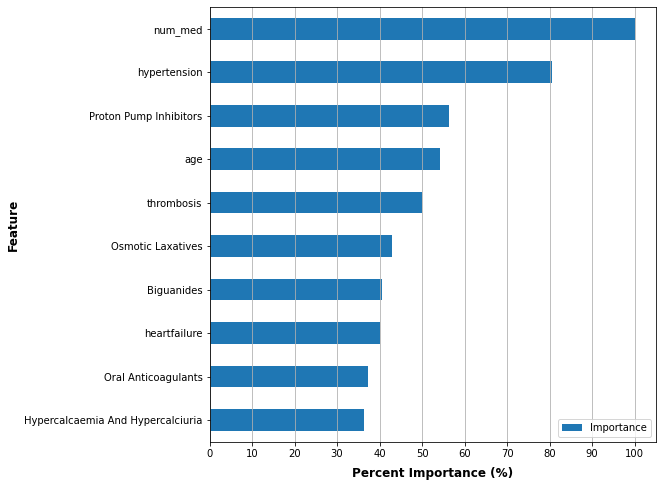

In [47]:
topk = 10

# sort model importances and take top k
sorted_importance = {k:v for k,v in sorted(model.get_score(importance_type='gain').items(),
                                           key=lambda item: item[1], reverse=True)[:topk]}

df = pd.DataFrame({'Feature': list(sorted_importance.keys())[:topk],
                   'Importance': 100*np.array(list(sorted_importance.values())[:topk])/\
                                 max(np.array(list(sorted_importance.values())))})

ax = df.plot(x='Feature', kind='barh', figsize=(8,8))
ax.invert_yaxis()
plt.xlabel('Percent Importance (%)', labelpad=8, fontsize='large', fontweight='demibold')
plt.ylabel('Feature', fontsize='large', fontweight='demibold')
plt.grid(axis='x')
ax.set_xticks(ticks=np.linspace(0,100,11))
plt.savefig('feature_importance.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

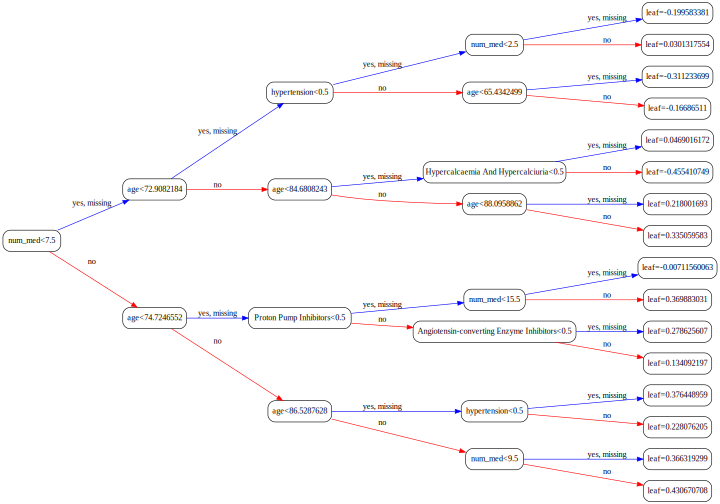

In [32]:
xgb.to_graphviz(model, num_trees=1, rankdir='LR', size='10,10',
                condition_node_params = {'shape': 'box',
                                         'style': 'rounded'},
#                                          'fillcolor': '#78bceb'},
                leaf_node_params = {'shape': 'box',
                                    'style': 'rounded'})

In [438]:
leaf_value = 0.4
1/(1+np.exp(-1*leaf_value))

0.598687660112452

In [ ]:

plt.plot(threshold, f1_scores,
         label=f'XGBClassifier (F1 = {round(np.max(f1_scores),2)})',
         marker='.', markersize=3)
plt.ylabel('F1-Score (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'
plt.xlabel('Threshold (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'

plt.axvline(x=threshold[np.argmax(accuracy_scores)], color='green', linestyle=(0,(3,4)), 
            label=f'x = {round(threshold[np.argmax(accuracy_scores)],3)}')

plt.grid(True)
plt.ylim(-0.02,0.42)
plt.savefig('f1_threshold.jpg', format='jpg', dpi=300)
plt.show()

print(f'max accuracy score: {np.max(accuracy_scores)}')

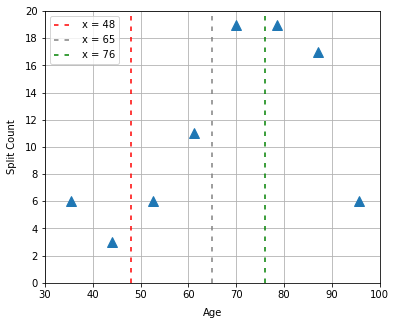

In [40]:
df = model.get_split_value_histogram('age', bins=8)

plt.figure(figsize=(6,5))
ax = plt.plot(round(df['SplitValue'],2), df['Count'], linestyle='None', marker='^', markersize=10)
plt.xlabel('Age', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylabel('Split Count', labelpad=8) # fontsize='large', fontweight='demibold')
plt.axvline(x=48, color='red', linestyle=(0,(3,4)), 
                        label=f'x = 48')
plt.axvline(x=65, color='grey', linestyle=(0,(3,4)), 
                        label=f'x = 65')
plt.axvline(x=76, color='green', linestyle=(0,(3,4)), 
                        label=f'x = 76')
plt.yticks(ticks=[0,2,4,6,8,10,12,14,16,18,20,22,24])
# plt.grid(axis='x')
plt.ylim(0,20)
plt.xlim(30,100)
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('age_split_ccb.jpg', format='jpg', dpi=300)
plt.show()